In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
from torch import Tensor
from tqdm.notebook import tqdm  # Progress bar

plt.style.use("ggplot")
%config InlineBackend.figure_formats = ['svg']

In [2]:
class LinearNet(nn.Module):
    def __init__(self,n_in,n_units):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_in,n_units),
            nn.ReLU(),
            nn.Linear(n_units,1),
        )
        
    def forward(self,x):
        return self.model(x)

In [3]:
net = LinearNet(2,16)

In [4]:
class AndDataset(data.Dataset):
    
    def __init__(self,n_samples):
        
        self.size = n_samples
        
        self.data = torch.rand((n_samples,2)) - 0.5
        
        self.label = self.data[:,0]*self.data[:,1] > 0
        
    def __len__(self):
        return self.size
    
    def __getitem__(self,idx):
        return self.data[idx],self.label[idx]

In [5]:
train_dataset = AndDataset(5000)

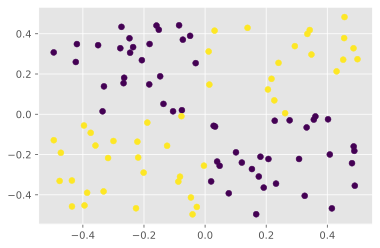

In [6]:
plt.scatter(train_dataset.data[:100,0],train_dataset.data[:100,1],c=train_dataset.label[:100])

In [7]:
train_data_loader = data.DataLoader(train_dataset,batch_size=16,shuffle=True)

In [8]:
loss_fn = nn.BCEWithLogitsLoss() # combine sigmoid and BCE

In [9]:
optimizer = torch.optim.Adadelta(net.parameters())

In [10]:
test_dataset = AndDataset(100)
test_dataloader = data.DataLoader(test_dataset,batch_size=32)

In [11]:
num_epochs = 21

epochs = []
loss_mean = []
loss_std = []
test_acc = []

for epoch in tqdm(range(num_epochs)):
    
    losses = []

    for X,y in train_data_loader:
        preds = net(X).squeeze()
        
        loss = loss_fn(preds,y.to(torch.float32))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        losses.append(loss.item())
        
        correct = 0
        total = 0

    with torch.no_grad():
        for X,y in test_dataloader:
            preds = net(X).squeeze() > 0.5 # threshold it to turn it into labels
            total += len(preds)
            correct += torch.sum(y == preds)

    test_acc.append(correct/total)
        
    loss_mean.append(np.mean(losses))
    loss_std.append(np.std(losses))
 
    epochs.append(epoch)

loss_mean = np.array(loss_mean)
loss_std = np.array(loss_std)

  0%|          | 0/21 [00:00<?, ?it/s]

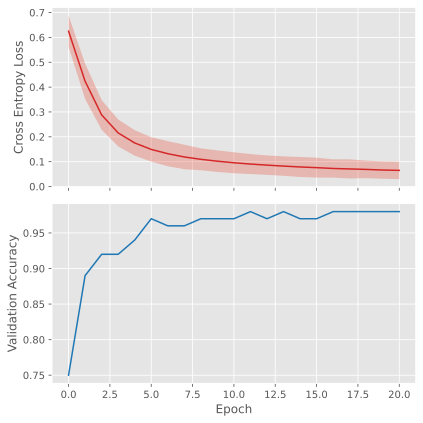

In [12]:
fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax[0].plot(epochs,loss_mean,color="tab:red")
ax[0].fill_between(epochs,loss_mean - loss_std, loss_mean + loss_std,alpha=0.3)
ax[0].set_ylabel("Cross Entropy Loss")

ax[1].plot(epochs,test_acc,color="tab:blue")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Accuracy")

fig.tight_layout()